**PAIRS TRADING**

In [1]:
!pip install yfinance
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=22321b03e64e39c212b699ad2cabea01c33d1b075193428bcf924e8a97df04f8
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
sns.set(style = "whitegrid")
from statsmodels.tsa.stattools import adfuller, coint
from datetime import datetime, timedelta

In [25]:
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=5*365)).strftime("%Y-%m-%d")

stocks = [
    # Technology
    "AAPL", "MSFT", "NVDA",
    # Finance
    "JPM", "BAC", "GS",
    # Energy
    "XOM", "CVX", "COP",
    # Consumer Staples
    "PG", "KO", "WMT",
    # Healthcare
    "JNJ", "UNH", "PFE",
    # Industrial
    "CAT", "BA", "MMM"
]

In [18]:
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
print(data.head())


[*********************100%%**********************]  18 of 18 completed

Ticker           AAPL          BA        BAC  ...         UNH        WMT        XOM
Date                                          ...                                  
2019-06-28  47.753017  357.526611  25.610085  ...  226.454803  34.021881  59.639572
2019-07-01  48.628830  350.111084  25.980984  ...  225.183380  34.061909  59.585075
2019-07-02  48.913536  347.852051  25.742548  ...  226.417725  34.363670  58.931316
2019-07-03  49.318878  348.156494  25.654238  ...  227.568481  34.585373  59.491692
2019-07-05  49.275444  349.521729  25.839691  ...  229.220444  34.480682  59.250416

[5 rows x 18 columns]


In [21]:
def cointegration_test(stock_data, stocks):
    N = len(stocks)
    pvalues = np.ones((N, N))
    stock_pairs = []

    for i in range(N):
        for j in range(i+1, N):
            result = coint(stock_data[stocks[i]], stock_data[stocks[j]])
            pval = result[1]
            pvalues[i, j] = pval
            pvalues[j, i] = pval

            if pval < 0.05:
                stock_pairs.append((pval, (stocks[i], stocks[j])))

    return pvalues, stock_pairs

In [22]:
pvalues, cointegrated_pairs = cointegration_test(data, stocks)

for pval, (stock1, stock2) in sorted(cointegrated_pairs):
    print(f"Cointegrated pair: {stock1} - {stock2} (p-value: {pval:.4f})")

Cointegrated pair: COP - KO (p-value: 0.0059)
Cointegrated pair: CVX - KO (p-value: 0.0094)
Cointegrated pair: PG - CAT (p-value: 0.0176)
Cointegrated pair: WMT - CAT (p-value: 0.0203)
Cointegrated pair: AAPL - PG (p-value: 0.0301)
Cointegrated pair: MSFT - WMT (p-value: 0.0311)
Cointegrated pair: XOM - KO (p-value: 0.0470)


In [23]:
min(cointegrated_pairs)

(0.00586510739049011, ('COP', 'KO'))

SELECTED PAIR : ConocoPhillips(COP) and Coca-Cola(KO)

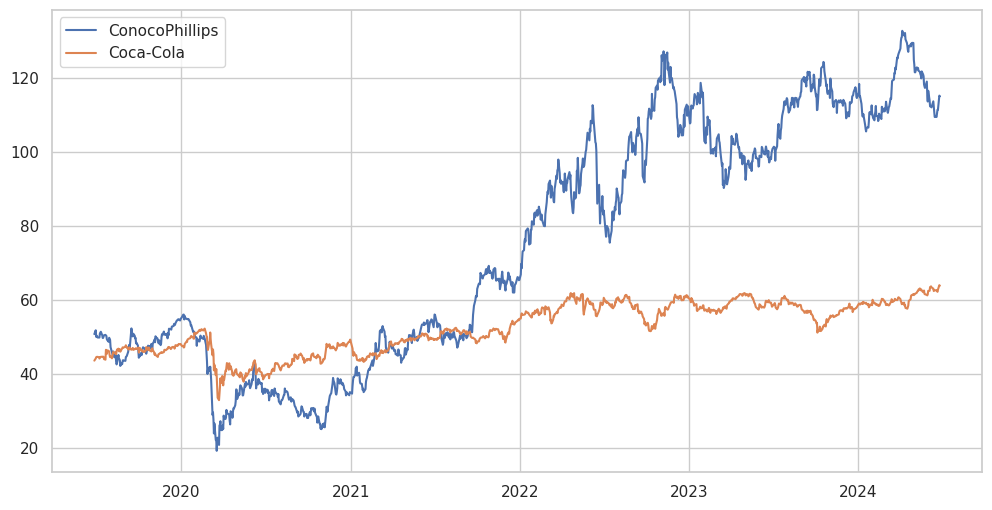

In [28]:
plt.figure(figsize = (12, 6))
plt.plot(data['COP'], label = 'ConocoPhillips')
plt.plot(data['KO'], label = 'Coca-Cola')
plt.legend()
plt.show()

In [94]:
stock_pair = ['COP', 'KO']
start_date = "2024-03-01"
end_date = "2024-04-23"

In [95]:
asset_pairs = yf.download(stock_pair, start=start_date, end=end_date)['Adj Close']
S1 = asset_pairs['COP']
S2 = asset_pairs['KO']

[*********************100%%**********************]  2 of 2 completed


In [96]:
spread = S1 - S2

**ZSCORE**

In [97]:
def zscore(S1, S2):
    lookback = 20
    scores = []
    for i in range(lookback, len(S1)):
        windowX = S1[i-lookback:i]
        windowY = S2[i-lookback:i]
        windowX = sm.add_constant(windowX)
        results = sm.OLS(windowY, windowX).fit()
        windowX = windowX['COP']
        b = results.params['COP']
        a = results.params['const']
        spread = windowY - b * windowX - a
        scores.append((spread[-1]-spread.mean())/spread.std())
    return pd.Series(scores, index = S1.index[lookback:])

In [98]:
zscores = zscore(S1,S2)

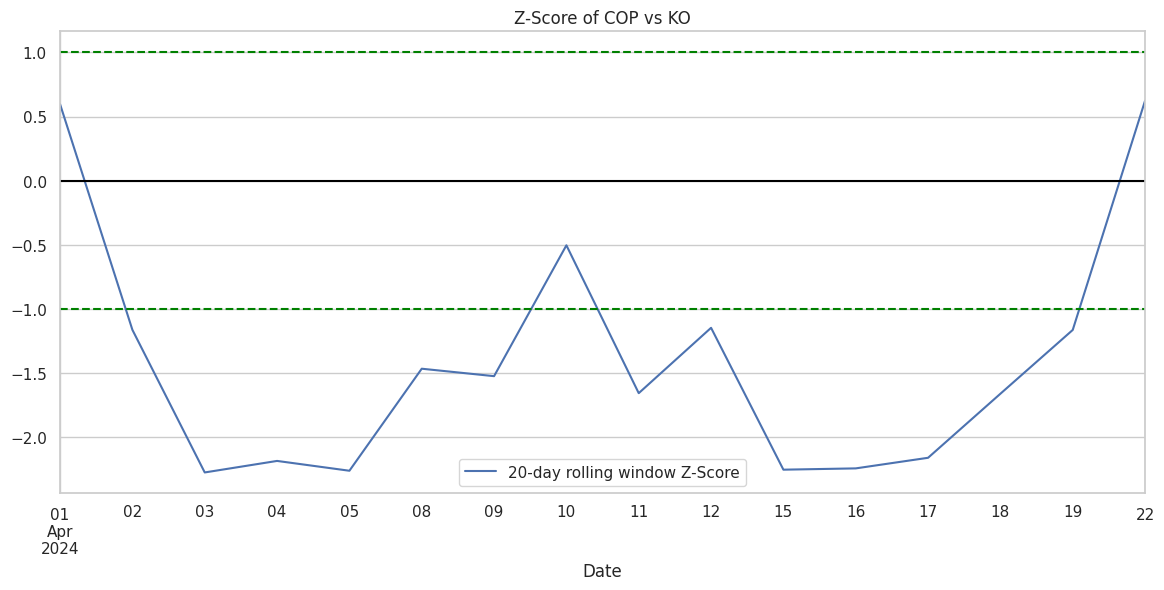

In [99]:
plt.figure(figsize=(14, 6))
zscores.plot()
plt.axhline(0.0, color='black')
plt.axhline(1.0, color='green', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.title('Z-Score of COP vs KO')
plt.legend(['20-day rolling window Z-Score'])
plt.show()

**GENERATING TRADE SIGNALS**

In [100]:
def generate_trade_signals(S1, S2, zscores):
    signals = pd.DataFrame()
    signals['price1'] = S1
    signals['price2'] = S2
    signals['zscore'] = zscores
    signals.dropna(inplace = True)
    signals['signal1'] = np.select([signals['zscore'] > 1, signals['zscore'] < -1], [1, -1], default = 0)
    signals['position1'] = signals['signal1'].diff()
    signals['signal2'] = -signals['signal1']
    signals['position2'] = signals['signal2'].diff()
    return signals

In [101]:
trade_signals = generate_trade_signals(S1, S2, zscores)
trade_signals.dropna(inplace = True)

In [102]:
def plot_pair_trades(trade_signals):
    fig = plt.figure(figsize=(14, 6))
    bx = fig.add_subplot(111)
    bx.plot(trade_signals['zscore'], c='#4abdac')
    bx.plot(trade_signals['zscore'][trade_signals['position1'] == -1], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)
    bx.plot(trade_signals['zscore'][trade_signals['position1'] == 1], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)
    plt.title(f'{stock_pair[1]} / {stock_pair[0]}')
    plt.legend(['Z-Score', 'Long', 'Short'])
    plt.show()


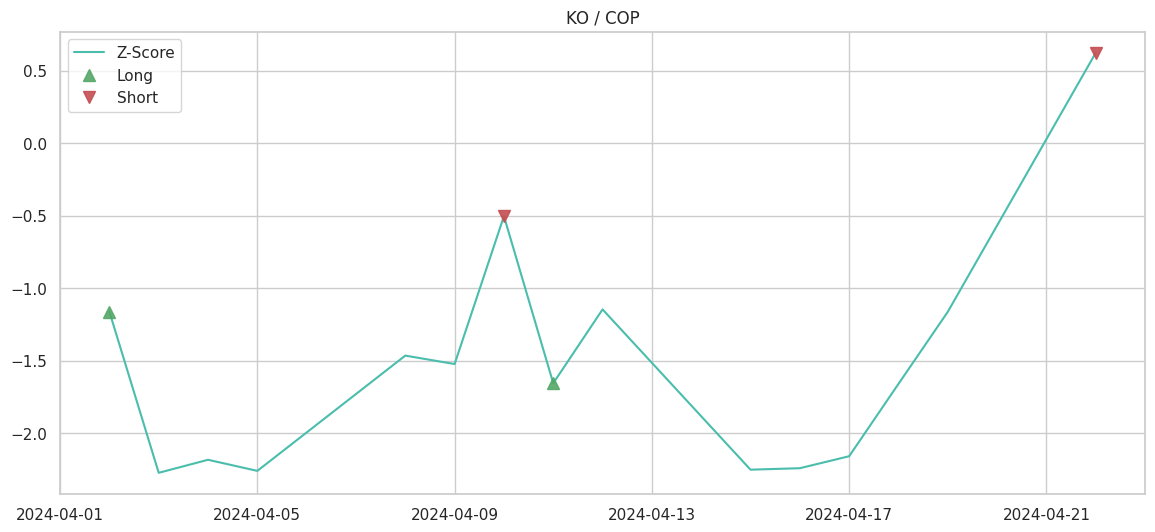

In [103]:
plot_pair_trades(trade_signals)


In [104]:
#PLOTTING TRADE ON COP
def plot_trades_1(signals):
    fig = plt.figure(figsize=(14,6))
    bx = fig.add_subplot(111)
    bx.plot(signals['price1'], c='#4abdac')
    bx.plot(signals['price1'][signals['position1'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
    bx.plot(signals['price1'][signals['position1'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
    plt.title(stock_pair[0])
    plt.legend(['Price', 'Long', 'Short'])
    plt.show()

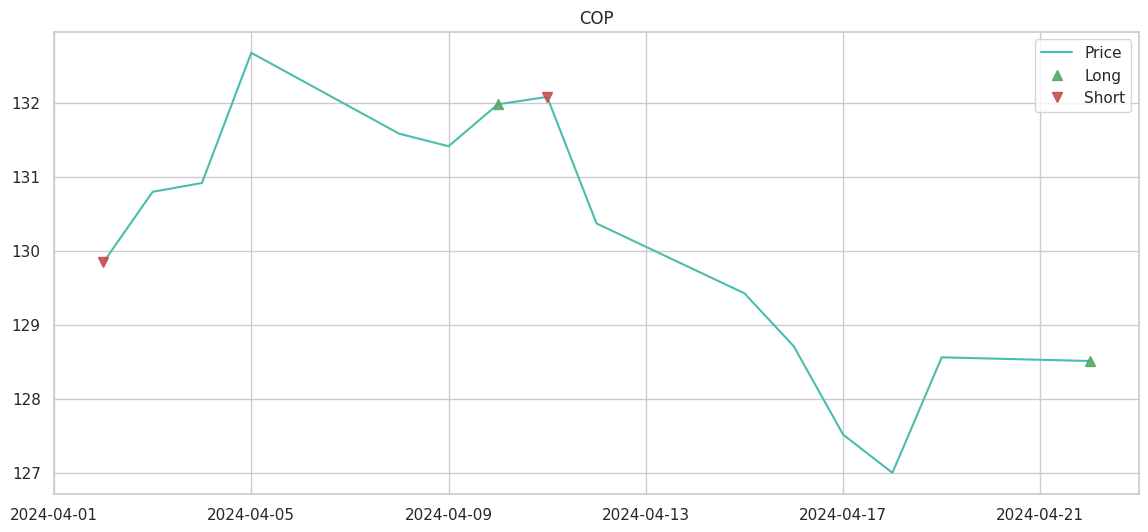

In [105]:
plot_trades_1(trade_signals)


In [106]:
#PLOTTING TRADE ON KO
def plot_trades_2(signals):
    fig = plt.figure(figsize=(14,6))
    bx = fig.add_subplot(111)
    bx.plot(signals['price2'], c='#4abdac')
    bx.plot(signals['price2'][signals['position2'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
    bx.plot(signals['price2'][signals['position2'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
    plt.title(stock_pair[1])
    plt.legend(['Price', 'Long', 'Short'])
    plt.show()

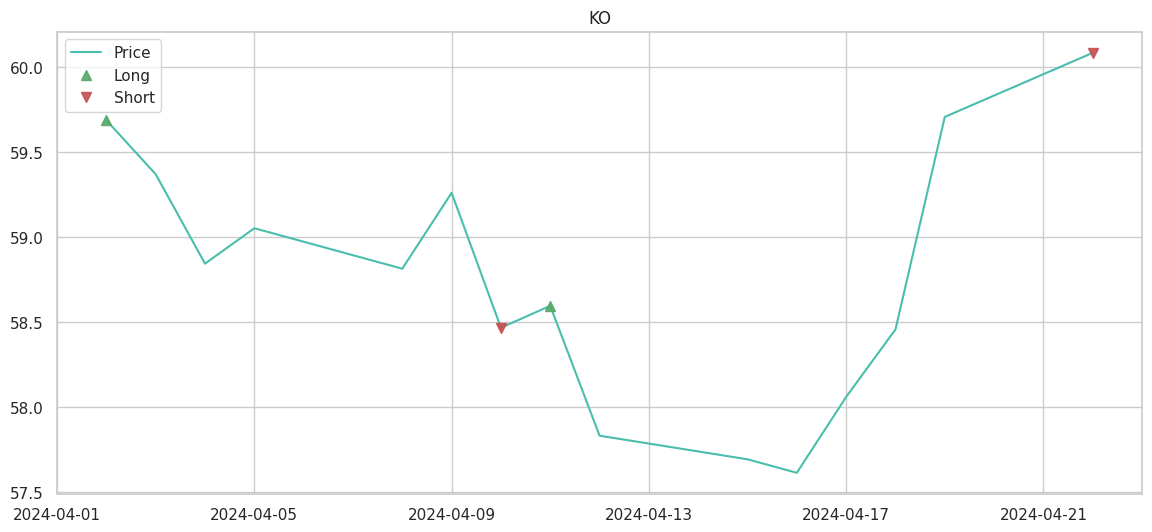

In [107]:
plot_trades_2(trade_signals)

**CALCULATING PNL**

In [108]:
def pnl_calculation(signals):
    initial_capital = 50000
    shares1 = initial_capital // (signals['price1'][0])
    shares2 = initial_capital // (signals['price2'][0])
    portfolio = pd.DataFrame()
    portfolio['holdings1'] = signals['position1'].cumsum() * signals['price1'] * shares1
    portfolio['cash1'] = initial_capital - (signals['position1'] * signals['price1'] * shares1).cumsum()
    portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total1'].pct_change()
    portfolio['holdings2'] = signals['position2'].cumsum() * signals['price2'] * shares2
    portfolio['cash2'] = initial_capital - (signals['position2'] * signals['price2'] * shares2).cumsum()
    portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total2'].pct_change()
    portfolio['total'] = portfolio['total1'] + portfolio['total2']
    portfolio = portfolio.dropna()
    return portfolio


In [109]:
portfolio = pnl_calculation(trade_signals)


**PORTFOLIO VALUE**

In [110]:
def plot_portfolio_value(portfolio):
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)
    ax.plot(portfolio['total'], c='g')
    ax.set_ylabel('Asset Value')
    ax.set_xlabel('Date')
    plt.title('Portfolio Performance PnL')
    plt.legend(['Total Portfolio Value'])
    plt.show()

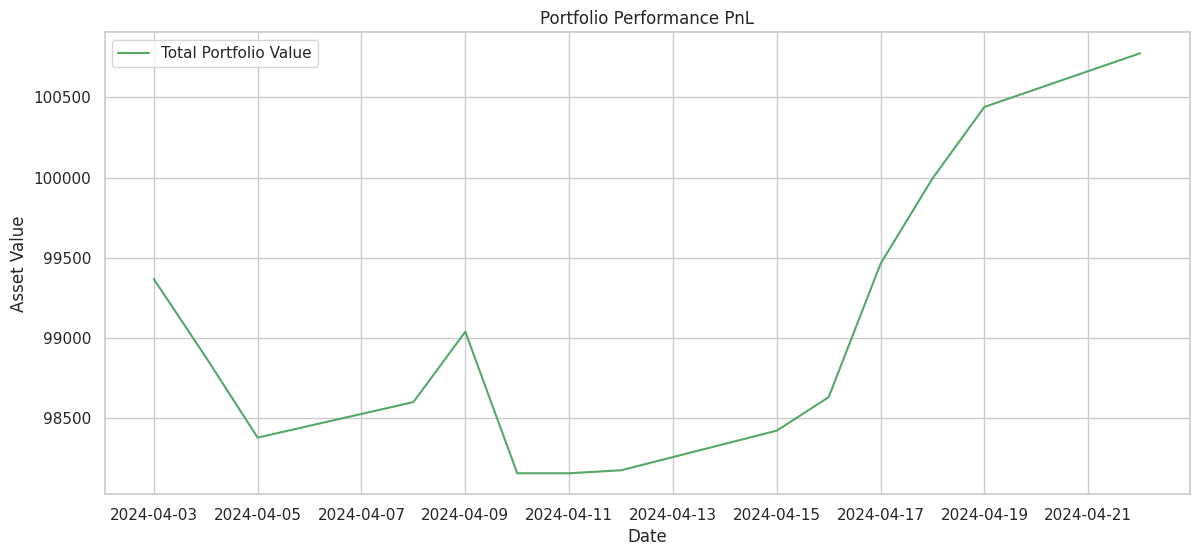

In [111]:
plot_portfolio_value(portfolio)


**CALCULATING CAGR**

In [112]:
def calculate_cagr(portfolio):
    final_portfolio = portfolio['total'].iloc[-1]
    initial_portfolio = portfolio['total'].iloc[0]
    delta = len(portfolio.index)
    print('Number of trading days = ', delta)
    YEAR_DAYS = 252
    returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
    return returns

In [113]:
print('CAGR = {:.3f}%' .format(calculate_cagr(portfolio) * 100))


Number of trading days =  14
CAGR = 28.827%


[*********************100%%**********************]  1 of 1 completed


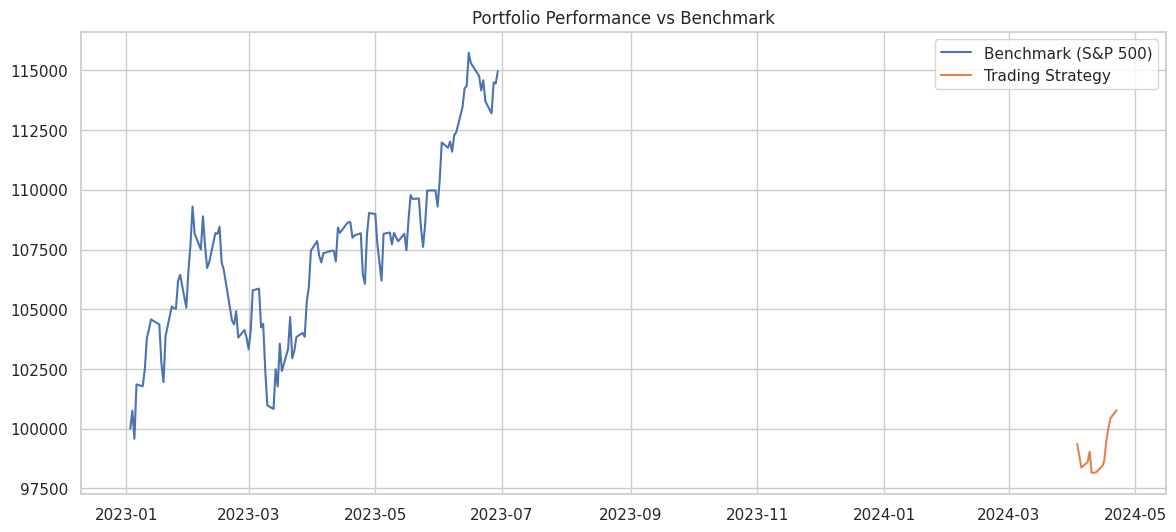

In [114]:
index = yf.download('^GSPC', start = '2023-01-01', end = '2023-06-30')['Adj Close']
shares = 100000/index[0]
plt.figure(figsize = (14, 6))
plt.plot(index*shares)
plt.plot(portfolio['total'])
plt.title('Portfolio Performance vs Benchmark')
plt.legend(['Benchmark (S&P 500)', 'Trading Strategy'])
plt.show()

In [115]:
cagr_index = (index.iloc[-1] / index[0])**(252/len(index)) - 1
print("CAGR of S&P 500:", np.round(cagr_index*100, 3), "%")
cagr_portfolio = (portfolio['total'].iloc[-1] / portfolio['total'].iloc[0]) ** (252/len(portfolio)) - 1
print("CAGR of trading strategy:", np.round(cagr_portfolio*100, 3), "%")

CAGR of S&P 500: 33.073 %
CAGR of trading strategy: 28.827 %
